In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat, u_darrays
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [3]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [23]:
ar = xr.open_dataarray(cnst.GRIDSAT + 'aggs/WAbox_meanT-50_hov_5000km2.nc')


In [ ]:
chirps = xr.open_mfdataset(cnst.CHIRPS_MONTHLY + "*.nc", concat_dim='time',autoclose=True)
chirps = uda.flip_lat(chirps)
chov = chirps.sel(lat=slice(4.5,20), lon=slice(-10,10)).groupby('time.month').mean('time').mean('lon')

In [6]:
chirps = xr.open_mfdataset('/home/ck/DIR/cornkle/data/OBS/IMERG_HQ_precip_old/monthly/' + "*.nc4", concat_dim='time',autoclose=True)
#chirps = uda.flip_lat(chirps)
chov = chirps.sel(lat=slice(4.5,20), lon=slice(-10,10)).groupby('time.month').mean('time').mean('lon')

In [7]:
chov = chov.load()

(array([980., 186., 138., 159., 156., 144.,  54.,  26.,   9.,   8.]),
 array([1.6814716e-01, 3.7169987e+01, 7.4171829e+01, 1.1117367e+02,
        1.4817551e+02, 1.8517735e+02, 2.2217918e+02, 2.5918103e+02,
        2.9618286e+02, 3.3318472e+02, 3.7018655e+02], dtype=float32),
 <a list of 10 Patch objects>)

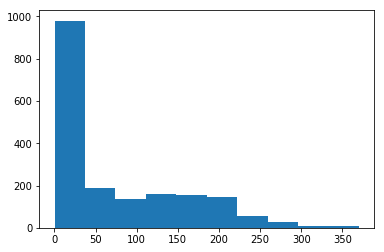

In [36]:
plt.hist(chov['precipitation'][:,:].values.flatten()*24*30)

In [10]:
era_pl = xr.open_dataset(cnst.ERA5_MONTHLY_PL_SYNOP)
era_pl = era_pl.where((era_pl['q'])['time.hour'] == 12, drop=True)
era_pl = u_darrays.flip_lat(era_pl)

In [11]:
era_srfc = xr.open_dataset(cnst.ERA5_MONTHLY_SRFC_SYNOP)
era_srfc = era_srfc.where((era_srfc['t2m'])['time.hour'] == 12, drop=True)
era_srfc = u_darrays.flip_lat(era_srfc)

In [12]:
era_srfc = era_srfc.sel(latitude=slice(4.5,20), longitude=slice(-10,10)).groupby('time.month').mean('time').mean('longitude')

/home/ck/miniconda3/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [13]:
era_pl = era_pl.sel(latitude=slice(4.5,20), longitude=slice(-10,10)).groupby('time.month').mean('time').mean('longitude')

In [14]:
u_shear = era_pl['u'].sel(level=slice(600,700)).mean('level') - era_pl['u'].sel(level=slice(900,925)).mean('level')
v_shear = era_pl['v'].sel(level=slice(600,700)).mean('level') - era_pl['v'].sel(level=slice(900,925)).mean('level')

ws, wd = u_met.u_v_to_ws_wd(u_shear,v_shear)

q = era_pl['q'].sel(level=slice(900,950)).mean('level')*1000
qmid = era_pl['q'].sel(level=700)
rh = era_pl['r'].sel(level=slice(900,950)).mean('level')
tdiff = era_pl['t'].sel(level=700)-era_pl['t'].sel(level=600)
theta_low = u_met.theta_e(925,era_pl['t'].sel(level=925).values-273.15,era_pl['q'].sel(level=925).values)
theta_high = u_met.theta_e(700,era_pl['t'].sel(level=700).values-273.15,era_pl['q'].sel(level=700).values)
thetadiff = theta_low-theta_high

thetad_low = u_met.theta(925,era_pl['t'].sel(level=925).values-273.15)
thetad_high = u_met.theta(700,era_pl['t'].sel(level=700).values-273.15)
thetadiffd = thetad_low-thetad_high


div = era_pl['d'].sel(level=slice(850,900)).mean('level') * (era_pl['q'].sel(level=slice(850,900)).mean('level')*1000)

tpw = era_srfc['tcwv']
cape = era_srfc['cape']

In [24]:
mean = ar.mean('year')

In [16]:
ws

array([[ 7.62455211,  7.15891694,  6.45392812,  5.37833296,  4.23784058,
         3.32083093,  2.50484837,  1.52506927,  1.44470026,  2.77682686,
         4.12551657,  5.44011923,  6.91612203,  8.33190369,  9.41098023,
        10.4082519 , 11.29304868, 11.93903689, 11.77350061, 12.10119453,
        12.3973564 , 12.95460651],
       [ 9.48343069,  8.83629158,  8.00597115,  6.83170335,  5.58641752,
         4.49315127,  3.40358484,  2.08609378,  0.82739586,  1.84938148,
         3.40671275,  4.86483815,  6.39692605,  7.8041065 ,  8.83028609,
         9.77638269, 10.63822921, 11.32861595, 11.36468528, 11.70331351,
        12.00148955, 12.57093997],
       [11.61575371, 11.10293615, 10.39890014,  9.43188911,  8.31948669,
         7.24934595,  6.08502605,  4.93202524,  3.58192861,  1.92122704,
         0.64562263,  1.90613734,  3.65074568,  5.37602566,  6.71967482,
         7.81938084,  8.75748799,  9.54975766,  9.86494453, 10.32199202,
        10.67920906, 11.18516368],
       [13.15467536

In [17]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(ax, data, lon, lat, l1, l2, nb,title=None,  text=None, mask_sig=None, quiver=None, contour=None, contour2=None, cbar_label=None,cmap=None):
    #mapp = ax.contourf(lon, lat, data, **kwargs)  # this is the actual plot
    nb_lev = nb
    cmapp = uplot.discrete_cmap(nb_lev, base_cmap=cmap)

#     mapp = ax.pcolormesh(np.arange(0.5,13,1), lat,data
#                           ,cmap=cmapp, vmin=l1, vmax=l2)
    
    mapp = ax.contourf(np.arange(1,13,1), lat,data, levels=np.round(np.linspace(l1,l2,nb),1), cmap=cmap )

    #cbar = plt.colorbar(mapp, ticks=np.linspace(l1,l2,nb_lev+1))
    cbar = plt.colorbar(mapp)
    plt.title(title)
    plt.text(0.03,0.85, text, transform=ax.transAxes, fontsize=14)
    ax.axhline(8.5, linestyle='dashed')
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.pcolormesh(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        plt.clabel(cs, inline=1, fontsize=8, fmt="%1.1f")
        
    if contour2 is not None:
        cs = ax.contour(contour2['x'], contour2['y'], contour2['data'], levels=contour2['levels'], colors=contour2['color'], linewidths=0.5 )
        plt.clabel(cs, inline=1, fontsize=8, fmt="%1.1f")
    
#     ax.coastlines()   ## adds coastlines
#     # Gridlines
#     xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
#     xl.xlabels_top = False   ## labels off
#     xl.ylabels_right = False
#     plt.title(title)
#     # Countries
#     ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
   # cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)   

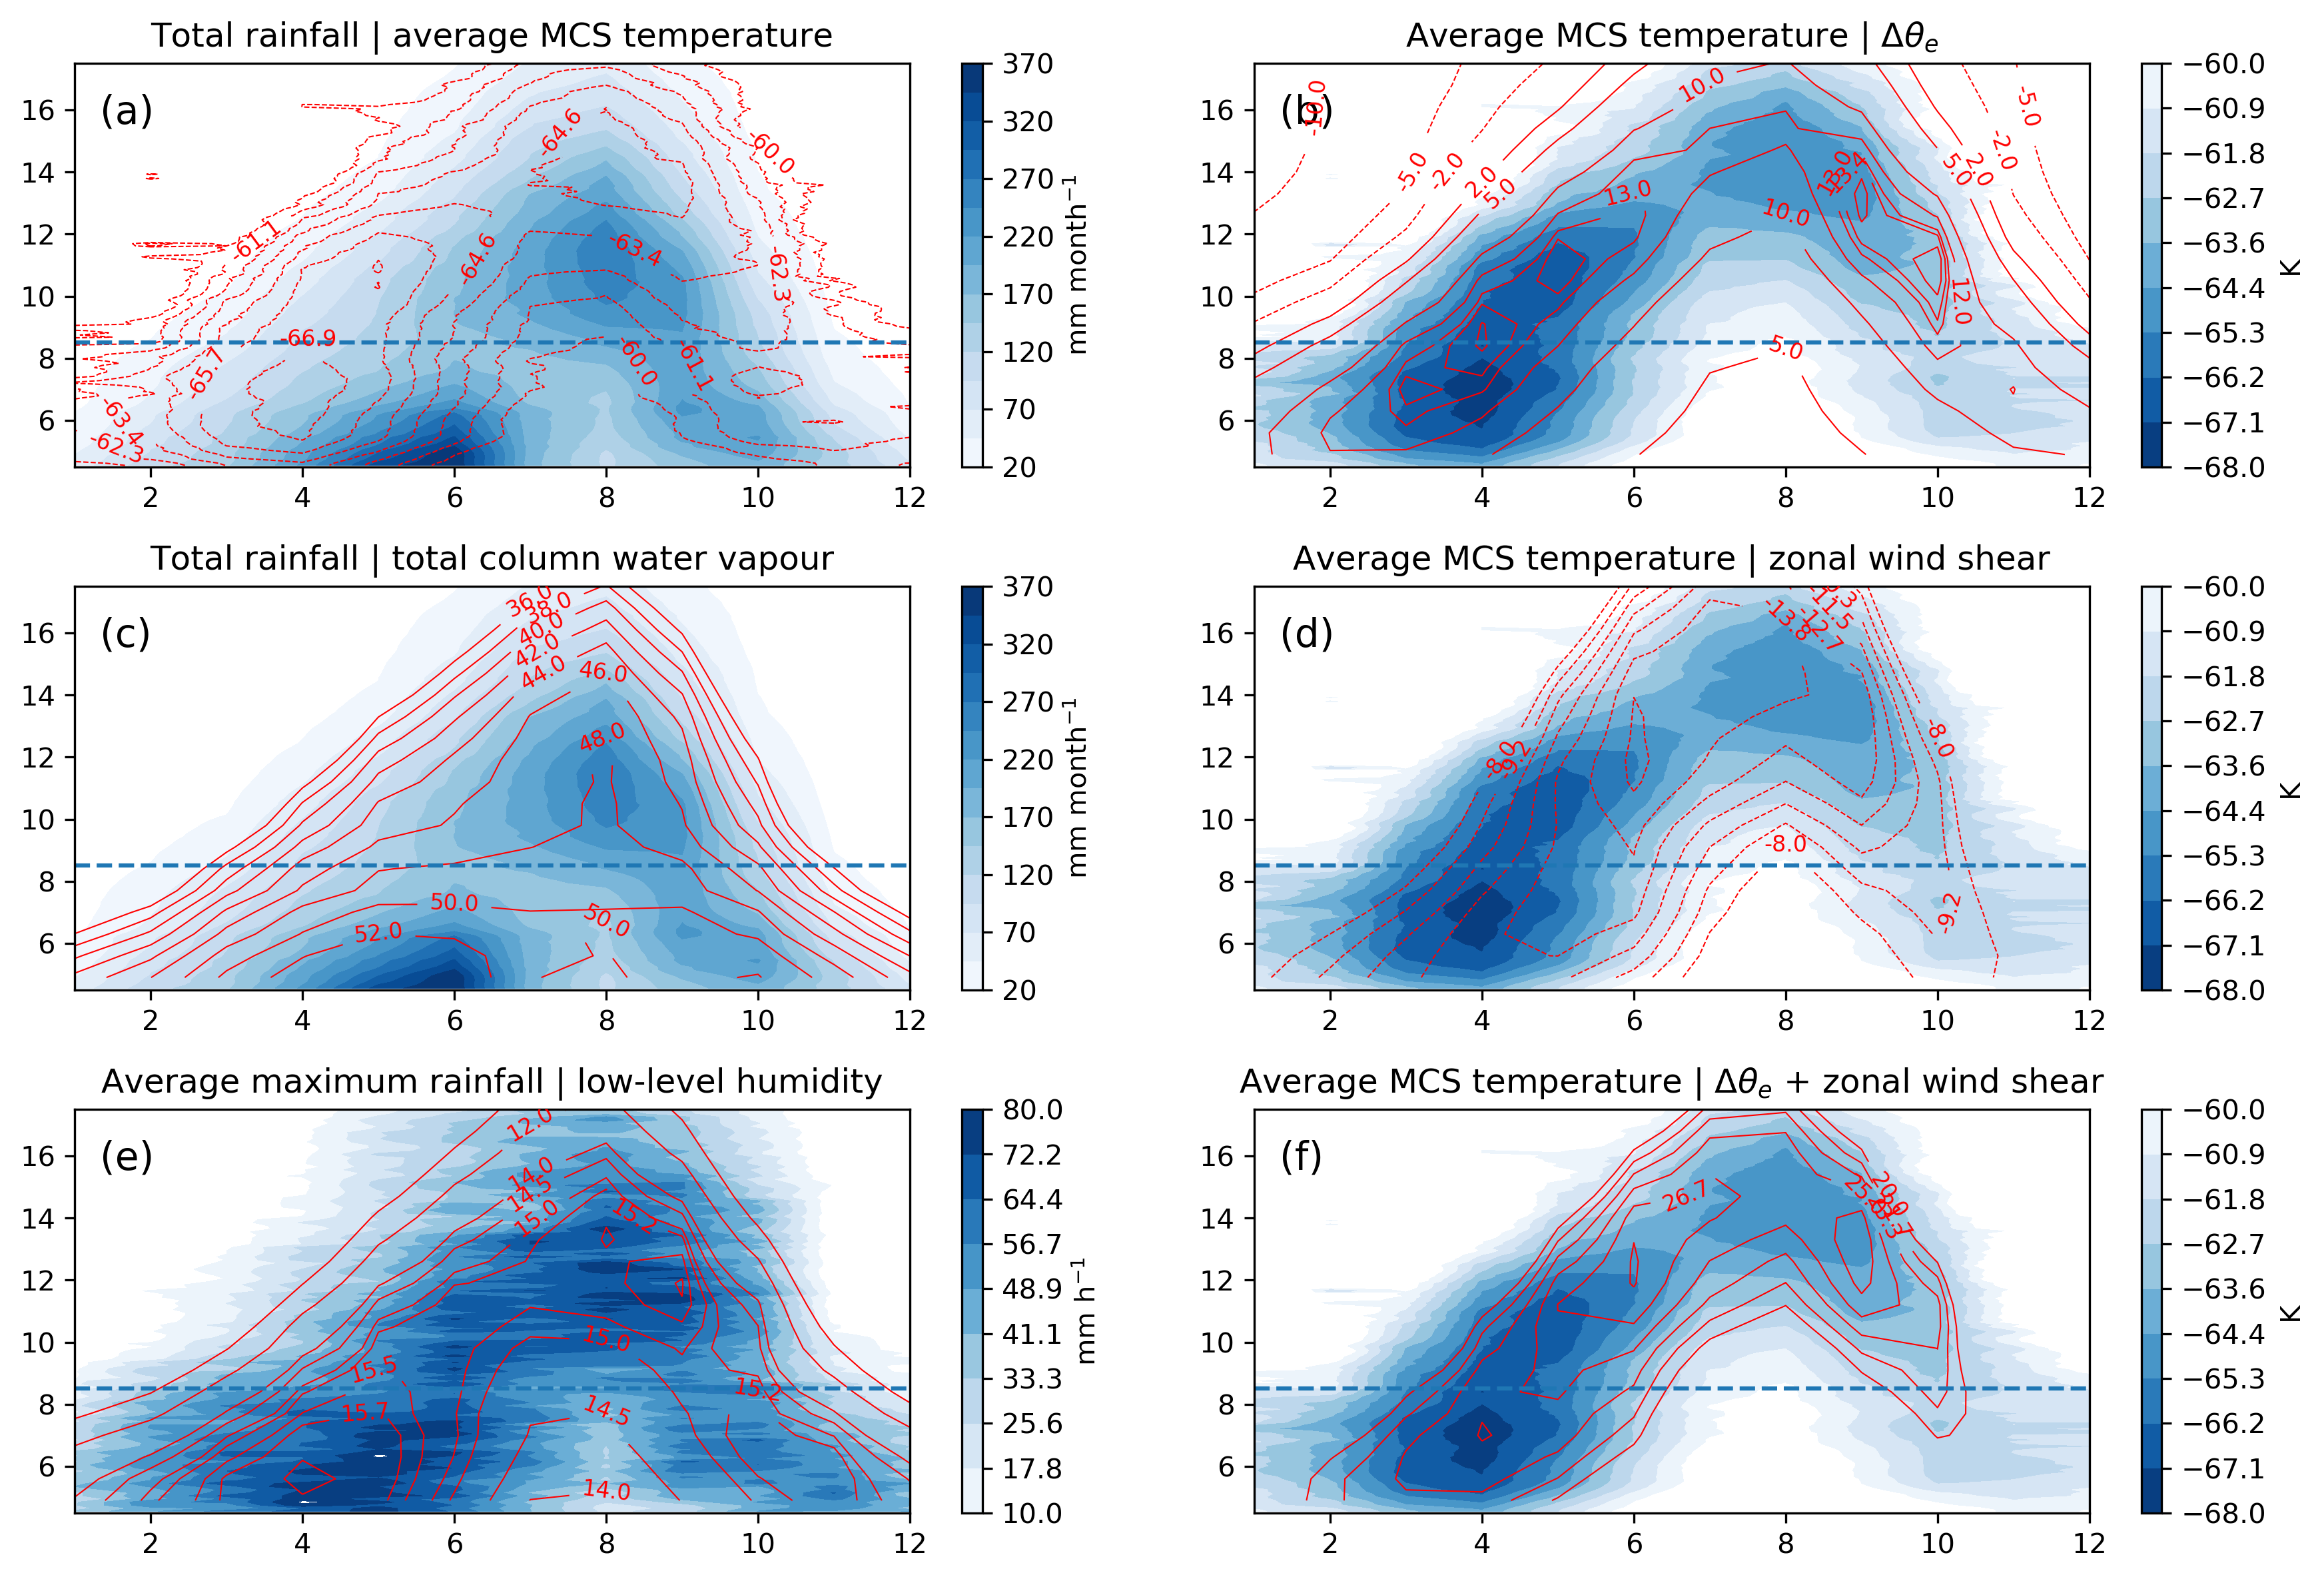

In [42]:
f = plt.figure(figsize=(12,8), dpi=300)
ax = f.add_subplot(325)
#contour = {'x' : chov.month.values, 'y': chov.lat.values, 'data': chov['precip'].values.T, 'levels': np.linspace(4,300,10), 'cmap':'jet'}
contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': q.T, 'levels': [10,12,14,14.5,15,15.2,15.5,15.7,16], 'color':'red'}
draw_map(ax, extr_rain.values.T[6::,:], np.arange(1,13,1), extr_rain.lat[6::], 10, 80, 10, cmap='Blues',  \
         title=r"Average maximum rainfall | low-level humidity", text='(e)', contour2=contour2, cbar_label='mm h$^{-1}$')

ax.set_ylim(4.5,17.5)

ax = f.add_subplot(323)
#contour = {'x' : chov.month.values, 'y': chov.lat.values, 'data': chov['precip'].values.T, 'levels': np.linspace(4,300,10), 'cmap':'jet'}
contour2 = {'x' : tpw.month.values, 'y': tpw.latitude.values, 'data': tpw.values.T, 'levels': np.arange(36,53,2), 'color':'red'}
draw_map(ax,chov['precipitation'].values.T*24*30 , chov.month.values, chov.lat.values, 20, 370,15, \
         title='Total rainfall | total column water vapour',  text='(c)',cmap='Blues',  contour2=contour2, cbar_label='mm month$^{-1}$')
ax.set_ylim(4.5,17.5)

ax1 = f.add_subplot(322)
#contour = {'x' : shear.month.values, 'y': shear.latitude.values, 'data': shear.values.T, 'levels': np.linspace(-12,-8 ,5), 'cmap':'viridis_r'}
#contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': shear.values.T, 'levels': np.linspace(-15,-8,10), 'color':'red'}
contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': thetadiff.T, 'levels': [-10,-5,-2,2,5,10,12,13, 13.4, 14], 'color':'red'}
draw_map(ax1, mean.values.T, mean.month, mean.lat, -68, -60, 10, cmap='Blues_r',  \
         title=r"Average MCS temperature | $\Delta \theta_e$", text='(b)', contour2=contour2, cbar_label='K')
ax1.set_ylim(4.5,17.5)

ax1 = f.add_subplot(324)
#contour = {'x' : shear.month.values, 'y': shear.latitude.values, 'data': shear.values.T, 'levels': np.linspace(-12,-8 ,5), 'cmap':'viridis_r'}
contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': u_shear.values.T, 'levels': np.linspace(-15,-8,7), 'color':'red'}
#contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': thetadiff.T, 'levels': [-10,-5,-2,2,5,10,12,13, 13.4, 14], 'color':'red'}
draw_map(ax1, mean.values.T, mean.month, mean.lat, -68, -60, 10, cmap='Blues_r', \
         title='Average MCS temperature | zonal wind shear', text='(d)', contour2=contour2, cbar_label='K')
ax1.set_ylim(4.5,17.5)

ax1 = f.add_subplot(326)
#contour = {'x' : shear.month.values, 'y': shear.latitude.values, 'data': shear.values.T, 'levels': np.linspace(-12,-8 ,5), 'cmap':'viridis_r'}
contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': np.abs(u_shear.values.T)+thetadiff.T, 'levels': np.linspace(20,30,7), 'color':'red'}
#contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': thetadiff.T, 'levels': [-10,-5,-2,2,5,10,12,13, 13.4, 14], 'color':'red'}
draw_map(ax1, mean.values.T, mean.month, mean.lat, -68, -60, 10, cmap='Blues_r', \
         title=r"Average MCS temperature | $\Delta \theta_e$ + zonal wind shear", text='(f)', contour2=contour2, cbar_label='K')
ax1.set_ylim(4.5,17.5)

ax1 = f.add_subplot(321)
#contour = {'x' : shear.month.values, 'y': shear.latitude.values, 'data': shear.values.T, 'levels': np.linspace(-12,-8 ,5), 'cmap':'viridis_r'}
contour2 = {'x' : mean.month, 'y': mean.lat, 'data': mean.values.T, 'levels': np.linspace(-68,-60,8), 'color':'red'}
#contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': thetadiff.T, 'levels': [-10,-5,-2,2,5,10,12,13, 13.4, 14], 'color':'red'}
draw_map(ax1,chov['precipitation'].values.T*24*30 , chov.month.values, chov.lat.values, 20, 370,15, cmap='Blues',  \
         title='Total rainfall | average MCS temperature', text='(a)', contour2=contour2, cbar_label='mm month$^{-1}$')
ax1.set_ylim(4.5,17.5)

plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/paper1/fig2.jpg')

In [19]:
extr_rain = xr.open_dataarray('/home/ck/DIR/cornkle/figs/CLOVER/maxRain_hov_GPM_17-19UTC.nc')

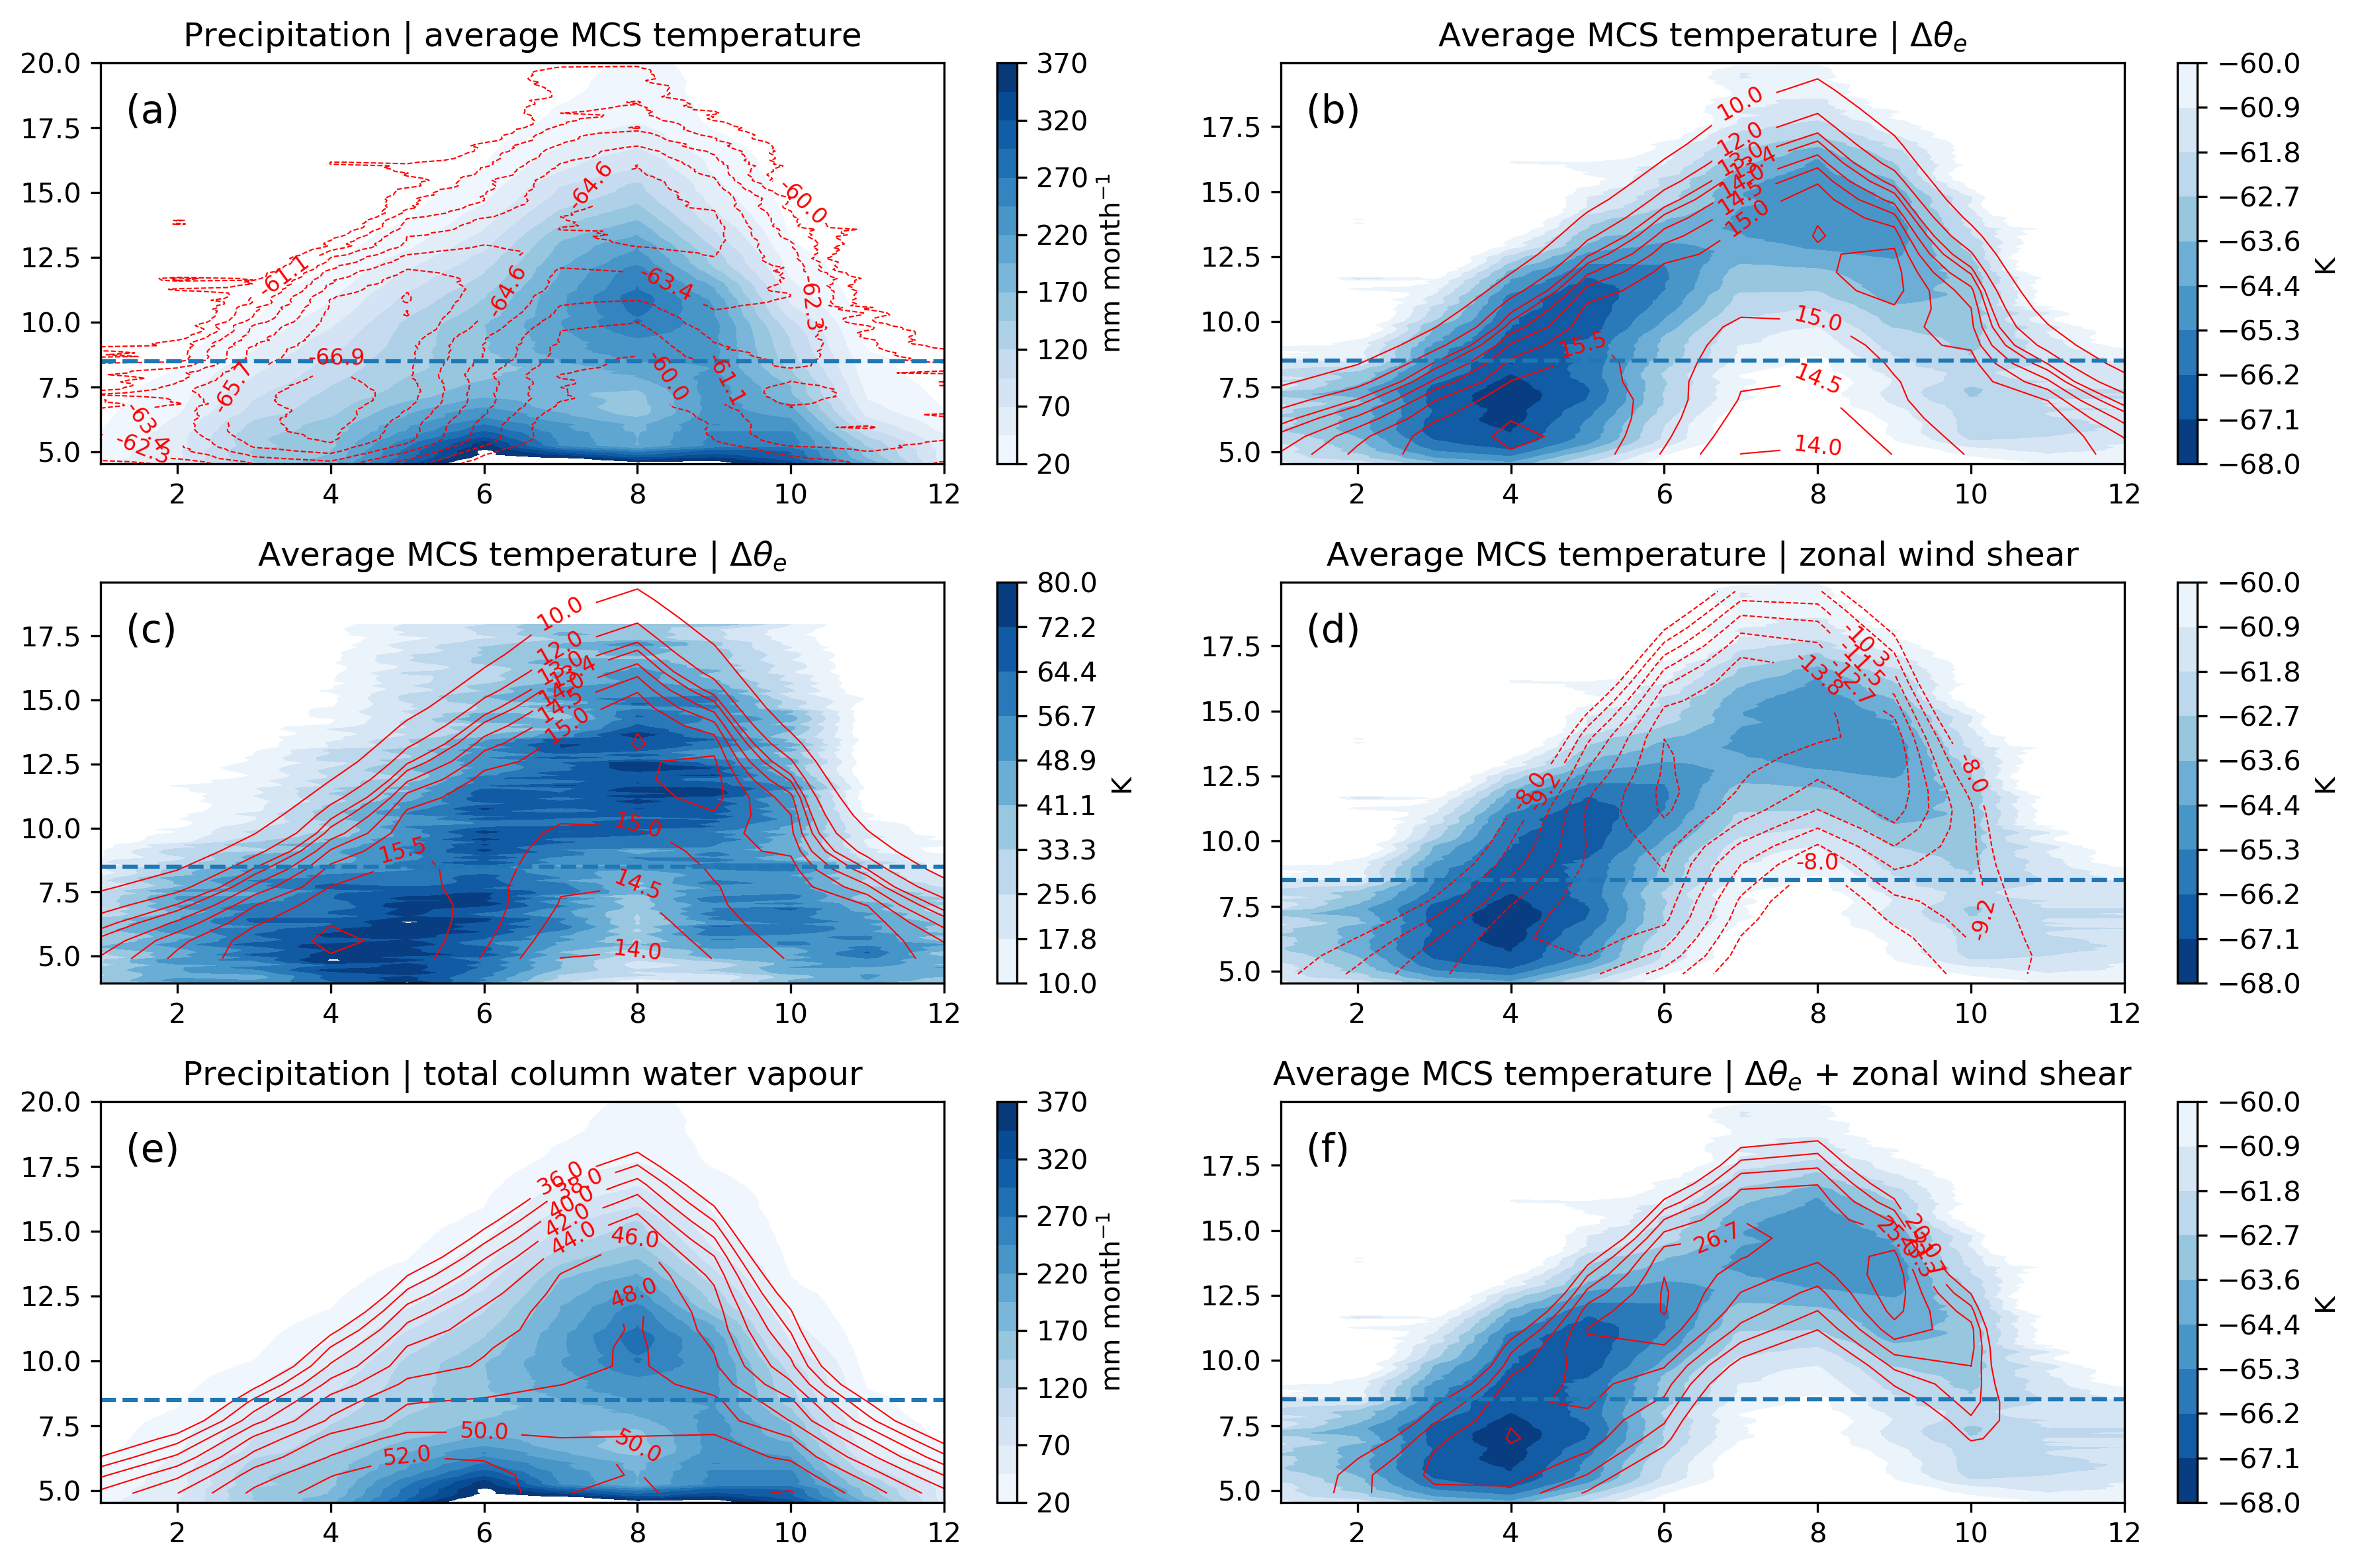

In [28]:
f = plt.figure(figsize=(12,8), dpi=300)
ax = f.add_subplot(323)
#contour = {'x' : chov.month.values, 'y': chov.lat.values, 'data': chov['precip'].values.T, 'levels': np.linspace(4,300,10), 'cmap':'jet'}
contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': q.T, 'levels': [-5,-2,10,12,13, 13.4, 14,14.5,15,15.5,16,16.5,17,17.5,18,18.5], 'color':'red'}
draw_map(ax, extr_rain.values.T, np.arange(1,13,1), extr_rain.lat, 10, 80, 10, cmap='Blues',  \
         title=r"Average MCS temperature | $\Delta \theta_e$", text='(c)', contour2=contour2, cbar_label='K')
# draw_map(ax, mean.values.T, mean.month, mean.lat, -68, -60, 10, cmap='Blues_r',  \
#          title=r"Average MCS temperature | $\Delta \theta_e$", text='(b)', contour2=contour2, cbar_label='K')



ax = f.add_subplot(325)
#contour = {'x' : chov.month.values, 'y': chov.lat.values, 'data': chov['precip'].values.T, 'levels': np.linspace(4,300,10), 'cmap':'jet'}
contour2 = {'x' : tpw.month.values, 'y': tpw.latitude.values, 'data': tpw.values.T, 'levels': np.arange(36,53,2), 'color':'red'}
draw_map(ax,chov['precip'].values.T , chov.month.values, chov.lat.values, 20, 370,15, \
         title='Precipitation | total column water vapour',  text='(e)',cmap='Blues',  contour2=contour2, cbar_label='mm month$^{-1}$')


ax1 = f.add_subplot(322)
#contour = {'x' : shear.month.values, 'y': shear.latitude.values, 'data': shear.values.T, 'levels': np.linspace(-12,-8 ,5), 'cmap':'viridis_r'}
#contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': shear.values.T, 'levels': np.linspace(-15,-8,10), 'color':'red'}
contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': q.T, 'levels': [-5,-2,10,12,13, 13.4, 14,14.5,15,15.5,16,16.5,17,17.5,18,18.5], 'color':'red'}
draw_map(ax1, mean.values.T, mean.month, mean.lat, -68, -60, 10, cmap='Blues_r',  \
         title=r"Average MCS temperature | $\Delta \theta_e$", text='(b)', contour2=contour2, cbar_label='K')

ax1 = f.add_subplot(324)
#contour = {'x' : shear.month.values, 'y': shear.latitude.values, 'data': shear.values.T, 'levels': np.linspace(-12,-8 ,5), 'cmap':'viridis_r'}
contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': u_shear.values.T, 'levels': np.linspace(-15,-8,7), 'color':'red'}
#contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': thetadiff.T, 'levels': [-10,-5,-2,2,5,10,12,13, 13.4, 14], 'color':'red'}
draw_map(ax1, mean.values.T, mean.month, mean.lat, -68, -60, 10, cmap='Blues_r', \
         title='Average MCS temperature | zonal wind shear', text='(d)', contour2=contour2, cbar_label='K')

ax1 = f.add_subplot(326)
#contour = {'x' : shear.month.values, 'y': shear.latitude.values, 'data': shear.values.T, 'levels': np.linspace(-12,-8 ,5), 'cmap':'viridis_r'}
contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': np.abs(u_shear.values.T)+thetadiff.T, 'levels': np.linspace(20,30,7), 'color':'red'}
#contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': thetadiff.T, 'levels': [-10,-5,-2,2,5,10,12,13, 13.4, 14], 'color':'red'}
draw_map(ax1, mean.values.T, mean.month, mean.lat, -68, -60, 10, cmap='Blues_r', \
         title=r"Average MCS temperature | $\Delta \theta_e$ + zonal wind shear", text='(f)', contour2=contour2, cbar_label='K')

ax1 = f.add_subplot(321)
#contour = {'x' : shear.month.values, 'y': shear.latitude.values, 'data': shear.values.T, 'levels': np.linspace(-12,-8 ,5), 'cmap':'viridis_r'}
contour2 = {'x' : mean.month, 'y': mean.lat, 'data': mean.values.T, 'levels': np.linspace(-68,-60,8), 'color':'red'}
#contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': thetadiff.T, 'levels': [-10,-5,-2,2,5,10,12,13, 13.4, 14], 'color':'red'}
draw_map(ax1,chov['precip'].values.T , chov.month.values, chov.lat.values, 20, 370,15, cmap='Blues',  \
         title='Precipitation | average MCS temperature', text='(a)', contour2=contour2, cbar_label='mm month$^{-1}$')


plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/paper1/fig2_0.jpg')